## Лабораторная работа №1. Логистическая регрессия в качестве нейронной сети

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn import metrics
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import numpy as np
import hashlib
import random
import pickle
import os

In [2]:
folder = 'notMNIST_large'
image_size = 28

In [3]:
label_encoder = LabelEncoder()
data = os.listdir(folder)
label_encoder.fit(data)

LabelEncoder()

## Загрузка данных

In [4]:
dataset_x = []
dataset_y = []
path = Path(folder)
for file_path in tqdm(list(path.rglob('*.png'))):
    try:
        image = Image.open(file_path)
        image.load()
        image = np.asarray(image, dtype=np.int16)
        dataset_x.append(image)
        dataset_y.append(file_path.parts[1])
    except:
        print('Could not read:', file_path)
    
dataset_x = np.asarray(dataset_x).reshape(len(dataset_x), image_size, image_size)
dataset_y = label_encoder.transform(dataset_y)

 36%|███▌      | 189996/529119 [00:22<00:43, 7775.52it/s]

Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png


 38%|███▊      | 200084/529119 [00:24<00:41, 7930.01it/s]

Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png


 38%|███▊      | 203361/529119 [00:24<00:40, 8126.44it/s]

Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png


 65%|██████▌   | 344283/529119 [00:41<00:22, 8397.67it/s]

Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png


 72%|███████▏  | 379513/529119 [00:45<00:17, 8556.62it/s]

Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png


100%|██████████| 529119/529119 [01:04<00:00, 8255.59it/s]


## Размер датасета (529114, 28, 28)

In [5]:
print(dataset_x.shape)
print(dataset_y.shape)

(529114, 28, 28)
(529114,)


## Вывод нескольких изображений из датасета

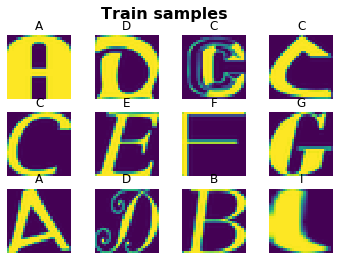

In [6]:
def plot_sample_dataset(dataset, labels, title):
    plt.suptitle(title, fontsize=16, fontweight='bold')
    items = random.sample(range(len(labels)), 12)
    for i, item in enumerate(items):
        plt.subplot(3, 4, i + 1)
        plt.axis('off')
        plt.title(chr(ord('A') + labels[item]))
        plt.imshow(dataset[item])
    plt.show()

plot_sample_dataset(dataset_x, dataset_y, 'Train samples')

## Гистограмма баланса классов

No handles with labels found to put in legend.


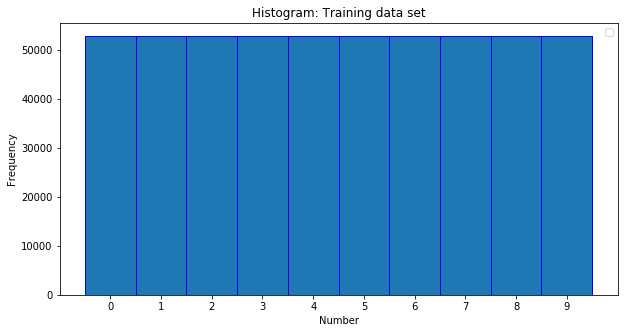

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.hist(dataset_y,bins=[0,1,2,3,4,5,6,7,8,9,10], edgecolor="b", histtype="bar",align='left')
ax.set_title('Histogram: Training data set')
ax.set(xlabel='Number', ylabel='Frequency')
ax.xaxis.set_ticks([0,1,2,3,4,5,6,7,8,9] );
ax.legend()

## Решейп 28х28 -> 784

In [8]:
dataset_x = np.reshape(dataset_x,(dataset_x.shape[0],image_size*image_size))

print(dataset_x.shape)
print(dataset_y.shape)

(529114, 784)
(529114,)


## Перемешиваем

In [9]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:]
    shuffled_labels = labels[permutation]
    
    return shuffled_dataset, shuffled_labels

dataset_x, dataset_y = randomize(dataset_x, dataset_y)

## Делим выборку на train, test, valid

In [10]:
X_train = dataset_x[:300000]
y_train = dataset_y[:300000]

X_test = dataset_x[300000:420000]
y_test = dataset_y[300000:420000]

X_valid = dataset_x[420000:]
y_valid = dataset_y[420000:]

## Убираем дубликаты в выборке

In [11]:
def sanitize(dataset_1, dataset_2, labels_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = []
    for i, hash1 in tqdm(enumerate(dataset_hash_1)):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)

X_test, y_test = sanitize(X_test, X_train, y_test)
X_valid, y_valid = sanitize(X_valid, X_train, y_valid)

120000it [09:59, 200.04it/s]
109114it [09:21, 194.42it/s]


## Нормализация данных

In [12]:
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

## Сохраняем выборки на диск

In [13]:
with open('X_train.pickle', 'wb') as f:
    pickle.dump(X_train, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('X_test.pickle', 'wb') as f:
    pickle.dump(X_test, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('X_valid.pickle', 'wb') as f:
    pickle.dump(X_valid, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('y_valid.pickle', 'wb') as f:
    pickle.dump(y_valid, f, protocol=pickle.HIGHEST_PROTOCOL)

## Обучение линейной регрессии на размере выборки 50, 100, 1000, 5000 и полной

In [14]:
def train_and_predict(sample_size, X_train_d, y_train_d, X_test_d, y_test_d):
    regr = LogisticRegression(max_iter=1000)
    X_train = X_train_d[:sample_size]
    y_train = y_train_d[:sample_size]
    regr.fit(X_train, y_train)

    pred_labels = regr.predict(X_test)

    print('Accuracy:', regr.score(X_test, y_test), 'when sample_size=', sample_size)

for sample_size in [50, 100, 1000, 5000, len(X_train)]:
    train_and_predict(sample_size, X_train, y_train, X_test, y_test)

Accuracy: 0.5351794732079437 when sample_size= 50
Accuracy: 0.6356533330738618 when sample_size= 100
Accuracy: 0.7531063606200072 when sample_size= 1000
Accuracy: 0.7504694812839948 when sample_size= 5000


/home/hd16547/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.8153114144765649 when sample_size= 300000
